# Solving the 1D Diffusion Equation with a Neural Network

In [2]:
import torch
from torch import nn
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [3]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *

In [4]:
# Double-precision by default
torch.set_default_dtype(torch.float64)

### 1D Diffusion Equation

In [5]:
# Functions below specify the initial boundary value problem (in terms of its residuals/deviations) alongside its analytic solution
def u0(u, x, t):
    return u - torch.sin(torch.pi * x), torch.zeros_like(u)

def dirichlet_bc(u, x, t):
    return u, torch.zeros_like(u)

def diffusion_equation(u, x, t):
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    return u_xx - u_t, torch.zeros_like(u)
diffusion_equation.domain_dim=2
diffusion_equation.target_dim=1

def u_analytical(x, t):
    return np.sin(np.pi * x) *np.exp(-(torch.pi)**2 * t)

def spatio_temporal_sample(T, N_st, N_s, N_t, kind="lhs"):
    if kind == "lhs":
        sampler1d = lambda N: torch.from_numpy(LatinHypercube(1).random(n = N))
        # Excludes boundaries naturally
        sampler2d = lambda N: torch.from_numpy(LatinHypercube(2).random(n = N))
    elif kind == "uniform":
        sampler1d = lambda N: torch.from_numpy(np.linspace(0, 1, N).reshape(-1,1))
        # Drop first and last
        sampler2d = lambda N: torch.from_numpy(np.dstack(np.meshgrid(sampler1d(N+2)[1:-1], 
                                                                     sampler1d(N+1)[1:])).reshape(-1, 2))
        N_st = int(np.sqrt(N_st))
        N_s = N_s // 2
    
    #Interior points
    samples_xt = sampler2d(N_st)
    #samples_x = samples_xt[:,0].reshape(-1,1)
    #samples_t = T * samples_xt[:,1].reshape(-1,1)
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = sampler1d(N_t)
    samples_t_ic = torch.zeros((N_t,1))
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_t_bc = torch.repeat_interleave(T * sampler1d(N_s), 2, dim=0)
    samples_x_bc = torch.empty((2 * N_s,1))
    samples_x_bc[0::2,0] = 0.
    samples_x_bc[1::2,0] = 1.
    
    return samples_xt, \
           torch.cat((samples_x_ic, samples_t_ic),1), \
           torch.cat((samples_x_bc, samples_t_bc), 1)

## Proof of Concept

### Generate Test/Train Split

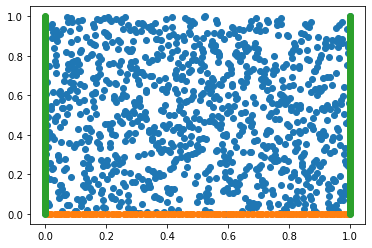

In [24]:
def unpack_sample(xt):
    return xt[:,0].reshape(-1,1), xt[:,-1].reshape(-1,1)

#IBVP parameters
T = 1
N_interior =  2**10
N_bc = 2**9
N_ic = 2**7

# Generate training set
X_train = spatio_temporal_sample(T, N_interior, N_bc, N_ic, kind="lhs")
xt_int, xt_ic, xt_bc = X_train

# Generate test data
X_test = spatio_temporal_sample(T, N_interior, N_bc, N_ic)

plt.scatter(*unpack_sample(xt_int))
plt.scatter(*unpack_sample(xt_ic))
plt.scatter(*unpack_sample(xt_bc))
#plt.scatter(x_boundary2, t_boundary, c="green")
plt.show()

### Training of the Network

In [29]:
diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, verbose=True)
print(diffusion_nn)
diffusion_nn.fit(X_train, None)

NN(
  (ff_graph): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=20, out_features=1, bias=True)
)
model parameters:                                                  921
---------------------------Hyperparameters----------------------------
hidden_layers                                             [20, 20, 20]
epochs                                                             200
number_of_minibatches                                                1
optimizer                                                        lbfgs

-----------------------------Training Log-----------------------------
# of collocation points:                                          1024
# of boundary points:                                             1024
# of initial condition:            

### Comparison between PiNN and Analytical Solution

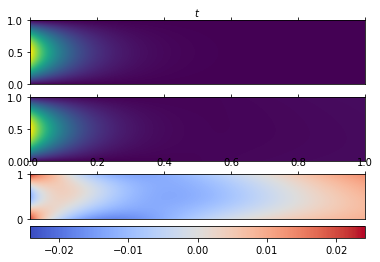

In [12]:
def dstack_product(x, y):
     return np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    
N_t = 1000
N_x = 900
t = np.linspace(0, T, N_t)
x = np.linspace(0, 1, N_x)
xx, tt = np.meshgrid(x,t)
u_ana = u_analytical(xx,tt)
xt = dstack_product(x,t)

X_test = torch.from_numpy(xt)
u_net = diffusion_nn.predict(X_test).reshape(N_t, N_x)

fig, ax = plt.subplots(nrows=3, sharex=True)

for a in ax:
    a.xaxis.tick_top()
    a.xaxis.set_label_position('top') 
for tk in ax[0].get_xticklabels():
    tk.set_visible(True)
for tk in ax[-1].get_xticklabels():
    tk.set_visible(True)
    
ax[0].pcolormesh(tt,xx,u_ana)
ax[1].pcolormesh(tt,xx,u_net)
im = ax[2].pcolormesh(tt, xx, u_net-u_ana,
                      cmap="coolwarm",
                      norm=colors.CenteredNorm())

divider = make_axes_locatable(ax[2])
cax = divider.new_vertical(size="25%", pad=0.1, pack_start=True)
fig.add_axes(cax)
cax.set_xlabel(r"$u_\text{analytical} - u_{net}$")
fig.colorbar(im, cax=cax, orientation="horizontal")

ax[0].set_xlabel(r"$t$")
plt.show()